In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Cleaning

In [3]:
sales = pd.read_parquet('sale_sample_18-21.parquet')
# township_codes = gpd.read_file('townships.geojson')
char_sample = pd.read_csv('char_sample.csv', dtype={'class': str}) # also has 'EX' in column
geo_info = pd.read_csv('parcels_geoinfo.csv')
cards = pd.read_csv('cards.csv')
cards.drop_duplicates(inplace=True)
# some are duplicates other than sqft and year built, same year and other info but diff sqft, so we drop it cuz this look anamolous
char_sample.drop_duplicates(subset=['year', 'pin','class'],inplace=True)

sales.year = sales.year.astype(int)
sales.pin = sales.pin.astype(int)
#sales.township = sales.township_code.astype(int)
#townships.township = townships.township.astype(int)
geo_info['class'] = geo_info['class'].astype(str)
geo_info.drop(['year'], axis=1,  inplace=True)
sales['class'] = sales['class'].astype(str)
sales.township_code = sales.township_code.astype(int)
sales = pd.merge(sales, geo_info, how='outer')
sales = pd.merge(sales, char_sample, )
sales = pd.merge(sales, cards)
sales = sales[sales['is_multisale'] != 1]
sales = sales[sales['card'] == 1]
sales.rename(columns = {'township_code_x': 'township_code'}, inplace=True)

In [4]:
sales

,pin,year,township_code,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,census_tract_geoid,lat,lon,sqft,year_built,card
0,2092050370000,2019.0,29,295,2019-05-01 00:00:00+00:00,201000.0,5.303196,96812985.0,1915417094,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1155.0,1985.0,1
1,20311070380000,2019.0,72,205,2019-09-01 00:00:00+00:00,215000.0,5.332438,98075139.0,1927355080,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1579.0,1947.0,1
2,10201120410000,2018.0,24,206,2018-07-01 00:00:00+00:00,540000.0,5.732394,97373057.0,1822817046,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,2256.0,1947.0,1
3,16183030040000,2022.0,27,203,2022-02-11 00:00:00+00:00,595000.0,5.774517,7321053.0,2206001050,01,...,None,NaN,NaN,NaN,NaN,NaN,NaN,1787.0,1918.0,1
4,10272320440000,2020.0,24,203,2020-04-01 00:00:00+00:00,285000.0,5.454845,96592558.0,2019607192,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1332.0,1953.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221429,3081110200000,2019.0,38,295,2019-07-01 00:00:00+00:00,553125.0,5.742823,98482344.0,1919755022,05,...,0,0.0,0.0,0.0,1.703180e+10,42.134879,-87.981232,2089.0,2018.0,1
221430,25212060060000,2021.0,72,202,2021-07-07 00:00:00+00:00,61000.0,4.785330,7209461.0,2120021039,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,918.0,1899.0,1
221431,7294030160000,2021.0,35,278,2021-08-30 00:00:00+00:00,220000.0,5.342423,7249327.0,2126546039,01,...,0,0.0,0.0,0.0,1.703180e+10,42.010148,-88.116944,2330.0,1966.0,1
221432,13251310310000,2018.0,77,203,2018-05-01 00:00:00+00:00,625000.0,5.795880,96260041.0,1815912107,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1102.0,1895.0,1


In [5]:
sales[sales.sale_key == 96737555.0]


,pin,year,township_code,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,census_tract_geoid,lat,lon,sqft,year_built,card
39716,32242000010000,2019.0,12,202,2019-01-01 00:00:00+00:00,650000.0,5.812913,96737555.0,1901608292,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,400.0,1923.0,1


# Variance - Outlier Detection

Just check number of deivations away from mean grouped by township_code.

Problems:

Would like to vary by geography, but how to join new geographies to table to do that? What is value in common? With spatial dataset could see what PINS in what unit, but we have no lat/long for data.


In [6]:
sales

,pin,year,township_code,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,census_tract_geoid,lat,lon,sqft,year_built,card
0,2092050370000,2019.0,29,295,2019-05-01 00:00:00+00:00,201000.0,5.303196,96812985.0,1915417094,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1155.0,1985.0,1
1,20311070380000,2019.0,72,205,2019-09-01 00:00:00+00:00,215000.0,5.332438,98075139.0,1927355080,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1579.0,1947.0,1
2,10201120410000,2018.0,24,206,2018-07-01 00:00:00+00:00,540000.0,5.732394,97373057.0,1822817046,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,2256.0,1947.0,1
3,16183030040000,2022.0,27,203,2022-02-11 00:00:00+00:00,595000.0,5.774517,7321053.0,2206001050,01,...,None,NaN,NaN,NaN,NaN,NaN,NaN,1787.0,1918.0,1
4,10272320440000,2020.0,24,203,2020-04-01 00:00:00+00:00,285000.0,5.454845,96592558.0,2019607192,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1332.0,1953.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221429,3081110200000,2019.0,38,295,2019-07-01 00:00:00+00:00,553125.0,5.742823,98482344.0,1919755022,05,...,0,0.0,0.0,0.0,1.703180e+10,42.134879,-87.981232,2089.0,2018.0,1
221430,25212060060000,2021.0,72,202,2021-07-07 00:00:00+00:00,61000.0,4.785330,7209461.0,2120021039,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,918.0,1899.0,1
221431,7294030160000,2021.0,35,278,2021-08-30 00:00:00+00:00,220000.0,5.342423,7249327.0,2126546039,01,...,0,0.0,0.0,0.0,1.703180e+10,42.010148,-88.116944,2330.0,1966.0,1
221432,13251310310000,2018.0,77,203,2018-05-01 00:00:00+00:00,625000.0,5.795880,96260041.0,1815912107,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1102.0,1895.0,1


In [7]:
def is_outlier_groupby(s: pd.Series, lower_lim : int, upper_lim: int) -> pd.DataFrame:
    """
    Finds values outside of std deviation range.
    Function meant for groupby() only.
    """
    lower_limit = s.mean() - (s.std() * lower_lim)
    upper_limit = s.mean() + (s.std() * upper_lim)
    return ~s.between(lower_limit, upper_limit)


def plot_std(df: pd.DataFrame, group: str, col: str, permuts: list) -> list:
    fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=len(permuts))
    stats = []
    outs = {}

    for tup in range(len(permuts)):
        std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
        no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
        std_outliers[col].plot.hist(ax=ax[tup, 0] )
        no_std_outliers[col].plot.hist(ax=ax[tup,1])
        fig.suptitle('Outliers - No Outliers')

        pct = len(std_outliers) / len(df.dropna(subset=[group, col]))
        stat = (len(std_outliers), pct)
        stats.append(stat)
        outs[permuts[tup]] = std_outliers

    print(stats)
    return outs


[(206, 0.00800901986703472), (299, 0.011624742428365926), (349, 0.013568679289296684), (899, 0.03495198475953501)]


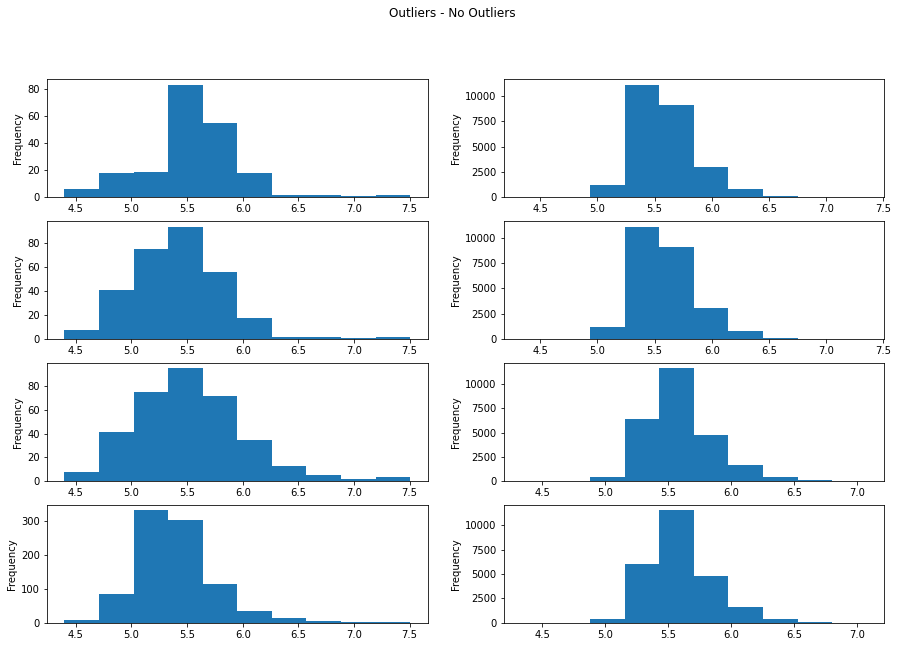

In [8]:
std_permutations = [(4,4), (3,4), (3,3), (2,3)]
census_sale_outs = plot_std(sales, 'census_tract_geoid', 'sale_price_log10', std_permutations)

[(610, 0.002796382123325036), (1663, 0.007623579460802516), (2189, 0.010034886013046727), (7875, 0.03610083478882731)]


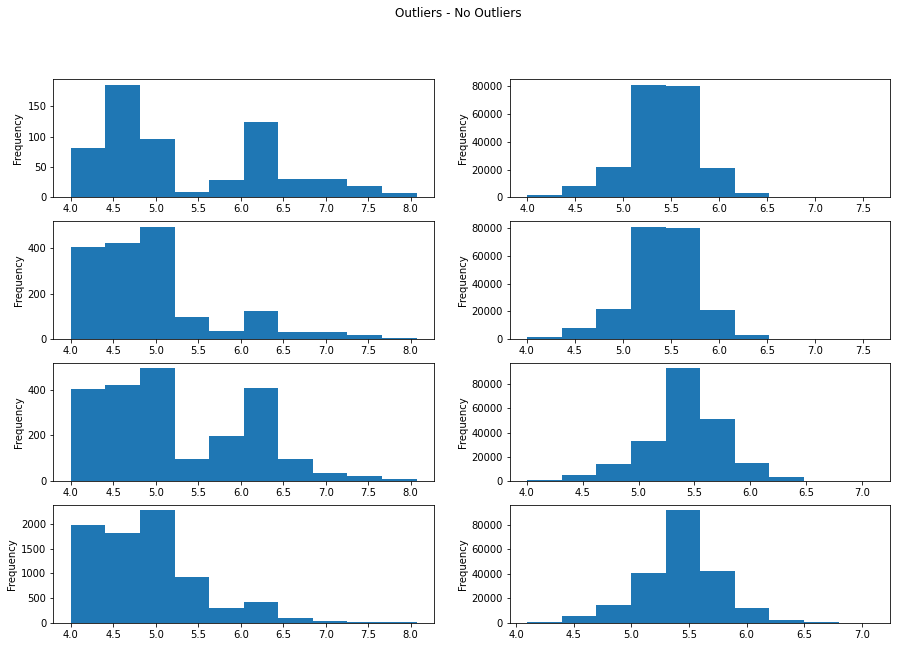

In [9]:
town_sale_outs = plot_std(sales, 'township_code', 'sale_price_log10', std_permutations)

### $ per sqft

In [10]:
sales['price_per_sqft'] = sales['sale_price'] / sales['sqft']
sales['price_per_sqft_log10'] = sales['sale_price_log10'] / sales['sqft']
sales['price_per_sqft'].replace([np.inf, -np.inf], np.nan, inplace=True)
sales['price_per_sqft_log10'].replace([np.inf, -np.inf], np.nan, inplace=True)

/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(372, 0.001706155920636231), (532, 0.0024399864241356852), (1249, 0.005728464367942615), (3766, 0.017272535476118404)]


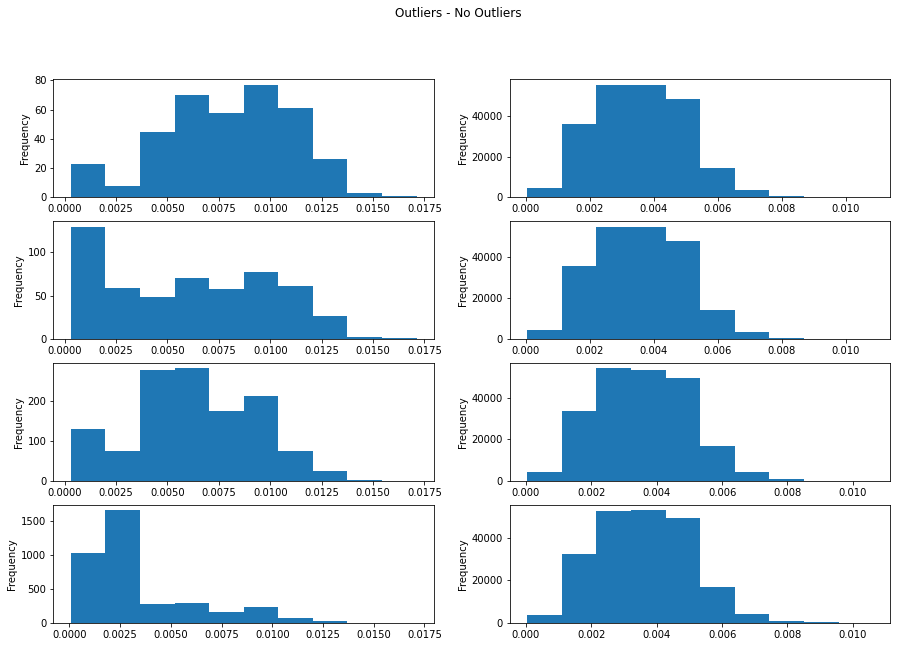

In [11]:
town_sqft_outs = plot_std(sales, 'township_code', 'price_per_sqft_log10', std_permutations)

[(171, 0.006648264064383189), (180, 0.006998172699350725), (227, 0.008825473348625637), (517, 0.020100307142024026)]


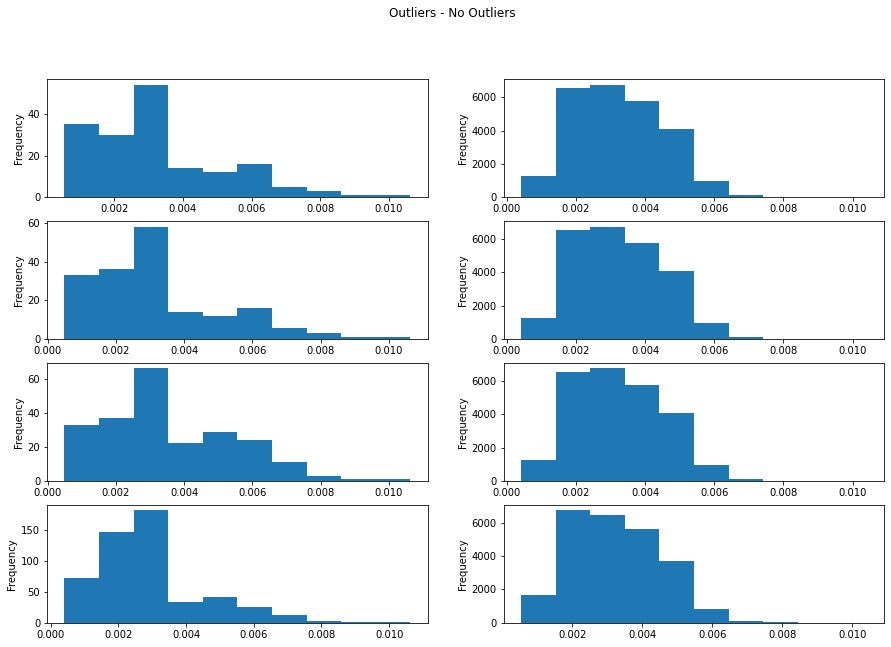

In [12]:
census_sqft_outs = plot_std(sales, 'census_tract_geoid', 'price_per_sqft_log10', std_permutations)

[(610, 0.002796382123325036), (1663, 0.007623579460802516), (2189, 0.010034886013046727), (7875, 0.03610083478882731)]


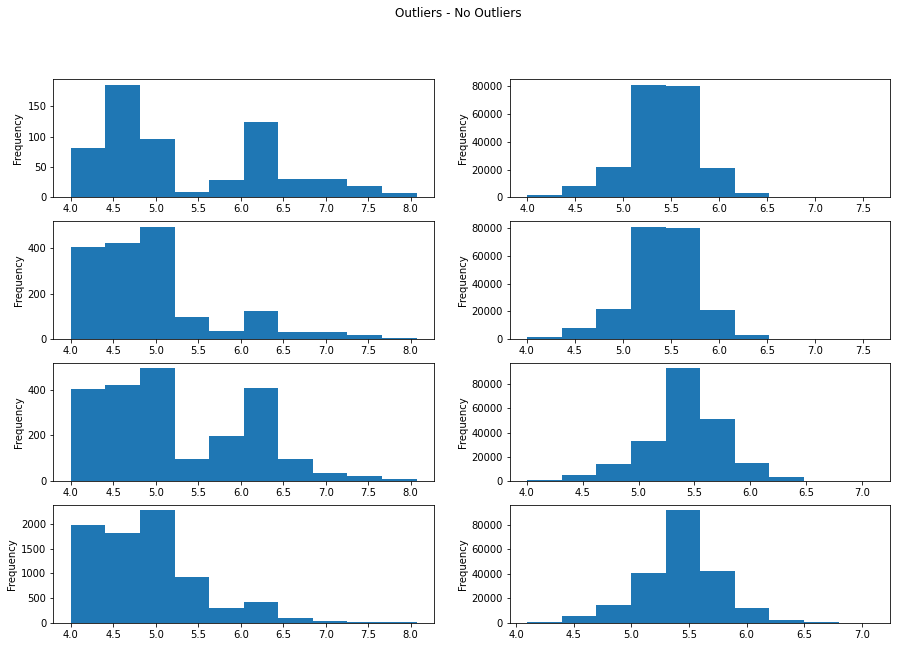

In [13]:
class_outs = plot_std(sales, 'township_code', 'sale_price_log10', std_permutations)

/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(384, 0.00176119320839869), (493, 0.0022611152389076933), (1199, 0.005499142335599035), (3305, 0.015158186337910601)]


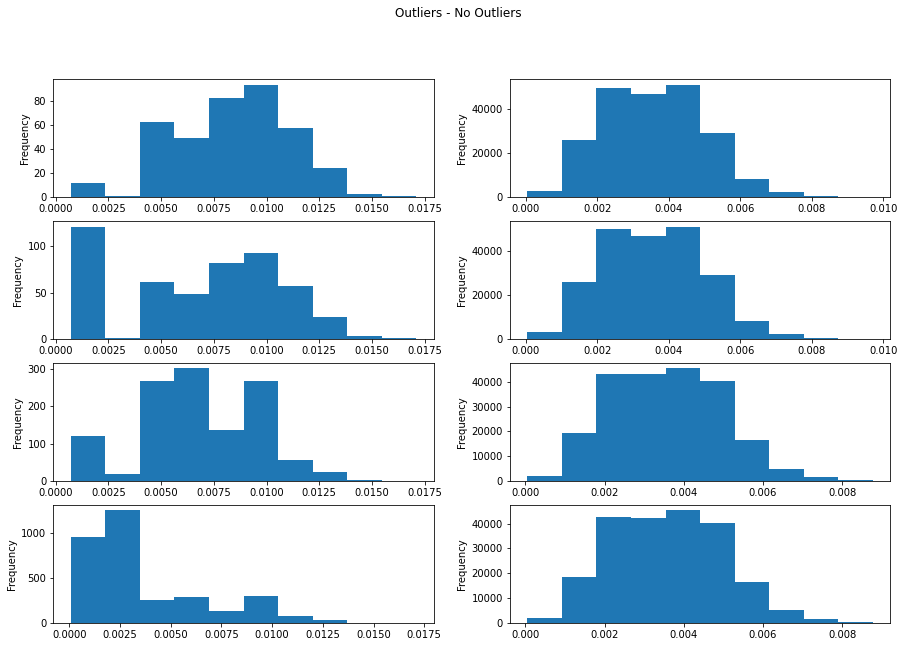

In [14]:
class_outs_sqft = plot_std(sales, 'class', 'price_per_sqft_log10', std_permutations)

#### Overlaps

In [15]:
# Between Township and Census for price
for tup in std_permutations:
    print(tup, len(town_sale_outs[tup]), len(census_sale_outs[tup]), len(pd.merge(town_sale_outs[tup], census_sale_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 610 206 30
(3, 4) 1663 299 89
(3, 3) 2189 349 117
(2, 3) 7875 899 415


In [16]:
# Between Township and Census for SQFT
for tup in std_permutations:
    print(tup, len(town_sqft_outs[tup]), len(census_sqft_outs[tup]), len(pd.merge(town_sqft_outs[tup], census_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 372 171 4
(3, 4) 532 180 6
(3, 3) 1249 227 26
(2, 3) 3766 517 116


In [17]:
# Within township for price and price/sqft
for tup in std_permutations:
    print(tup, len(town_sale_outs[tup]), len(town_sqft_outs[tup]), len(pd.merge(town_sale_outs[tup], town_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 610 372 15
(3, 4) 1663 532 32
(3, 3) 2189 1249 87
(2, 3) 7875 3766 520


In [18]:
# Within census for price and price/sqft
for tup in std_permutations:
    print(tup, len(census_sale_outs[tup]), len(census_sqft_outs[tup]), len(pd.merge(census_sale_outs[tup], census_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 206 171 159
(3, 4) 299 180 162
(3, 3) 349 227 170
(2, 3) 899 517 196


# Sale Volatility

Create buckets of which properties fall into which growth rates. Look at absolute value change, see if departing from value of area or moving towards.
See what portion of data illustrates particular outlier flag, and which ones illustrate several outlier flags.

In [19]:
sales['pct'] = sales.sort_values('sale_date').groupby('pin')['sale_price'].pct_change()
township_avg_change = sales.groupby(['township_code'])['pct'].mean()
township_mean = sales.groupby(['township_code'])['sale_price_log10'].mean()
class_mean = sales.groupby(['class'])['sale_price_log10'].mean()
town_class_mean = sales.groupby(['township_code', 'class'])['sale_price_log10'].mean()


sales.set_index('township_code', inplace=True)
sales['township_avg_change'] = township_avg_change
sales['township_mean_sale_log10'] = township_mean
sales['diff_from_township_mean_sale_log10'] = abs(sales['township_mean_sale_log10'] - sales['sale_price_log10'])
sales.reset_index(inplace=True)

sales.set_index('class', inplace=True)
sales['class_mean_sale_log10'] = class_mean
sales['diff_from_class_mean_sale_log10'] = abs(sales['class_mean_sale_log10'] - sales['sale_price_log10'])
sales.reset_index(inplace=True)

sales.set_index(['township_code', 'class'], inplace=True)
sales['town_class_mean_sale_log10'] = town_class_mean
sales['diff_from_town_class_mean_sale_log10'] = abs(sales['town_class_mean_sale_log10'] - sales['sale_price_log10'])
sales.reset_index(inplace=True)

<AxesSubplot:xlabel='township_mean_sale_log10', ylabel='township_avg_change'>

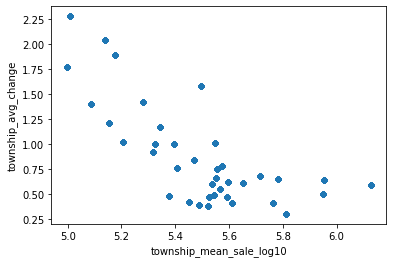

In [20]:
sales.plot.scatter(x='township_mean_sale_log10', y='township_avg_change')

In [21]:
sales[sales['township_code'] == 76]

,township_code,class,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10,class_mean_sale_log10,diff_from_class_mean_sale_log10,town_class_mean_sale_log10,diff_from_town_class_mean_sale_log10
12,76,211,16364000080000,2018.0,2018-10-01 00:00:00+00:00,118000.0,5.071882,97299586.0,1831319495,01,...,87.797619,0.003774,NaN,0.617168,5.596112,0.524230,5.445289,0.373407,5.553928,0.482046
23,76,211,17314120190000,2018.0,2018-12-01 00:00:00+00:00,221000.0,5.344392,98256241.0,1836134037,05,...,54.007820,0.001306,NaN,0.617168,5.596112,0.251720,5.445289,0.100897,5.553928,0.209536
37,76,211,17294270430000,2018.0,2018-02-01 00:00:00+00:00,236000.0,5.372912,97298082.0,1805841021,01,...,192.810458,0.004390,NaN,0.617168,5.596112,0.223200,5.445289,0.072377,5.553928,0.181016
91,76,203,17314180080000,2018.0,2018-07-01 00:00:00+00:00,265000.0,5.423246,96705202.0,1820718048,01,...,168.253968,0.003443,NaN,0.617168,5.596112,0.172866,5.304630,0.118616,5.462223,0.038977
136,76,203,17283180210000,2018.0,2018-08-01 00:00:00+00:00,385000.0,5.585461,97114308.0,1823612060,01,...,324.894515,0.004713,NaN,0.617168,5.596112,0.010652,5.304630,0.280830,5.462223,0.123238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217276,76,278,17324120380000,2018.0,2018-11-01 00:00:00+00:00,705000.0,5.848189,97522179.0,1833719138,01,...,321.917808,0.002670,NaN,0.617168,5.596112,0.252077,5.698623,0.149566,5.787702,0.060488
217496,76,202,17294090320000,2018.0,2018-06-01 00:00:00+00:00,368000.0,5.565848,97150948.0,1817149161,05,...,400.000000,0.006050,NaN,0.617168,5.596112,0.030265,5.152864,0.412984,5.334224,0.231623
217986,76,203,17312210040000,2020.0,2020-09-16 00:00:00+00:00,310000.0,5.491362,7098657.0,2032507219,01,...,197.075652,0.003491,NaN,0.617168,5.596112,0.104751,5.304630,0.186731,5.462223,0.029139
218010,76,212,17282110020000,2018.0,2018-04-01 00:00:00+00:00,570000.0,5.755875,98336720.0,1810318075,01,...,186.274510,0.001881,NaN,0.617168,5.596112,0.159762,5.548905,0.206970,5.765832,0.009957


<AxesSubplot:ylabel='Frequency'>

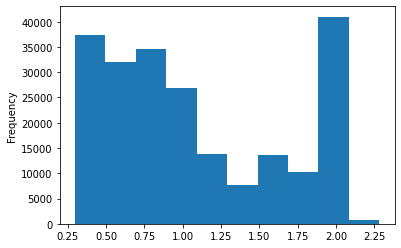

In [22]:
sales.township_avg_change.plot.hist()

## Between transactions for the same property

In [23]:
dups = sales[sales.pin.duplicated(keep=False)]

In [24]:
v_counts = dups.pin.value_counts().reset_index().rename(columns={'index':'pin', 'pin':'counts'})

In [25]:
def is_outlier_column(df: pd.DataFrame, col: str, lower_lim, upper_lim):
    """
    Function that calculates outliers for pandas columns.
    Contrat with is_outlier_groupby().
    """
    lower_limit = df[col].mean() - (df[col].std() * lower_lim)
    upper_limit = df[col].mean() + (df[col].std() * upper_lim)
    return df[~df[col].between(lower_limit, upper_limit)]


In [26]:
count_outliers = {}
for std in std_permutations:
    count_outliers[std] = is_outlier_column(v_counts, 'counts', std[0], std[1])

In [27]:
for tup in std_permutations:
    print(tup, len(count_outliers[tup]))

(4, 4) 170
(3, 4) 170
(3, 3) 170
(2, 3) 170


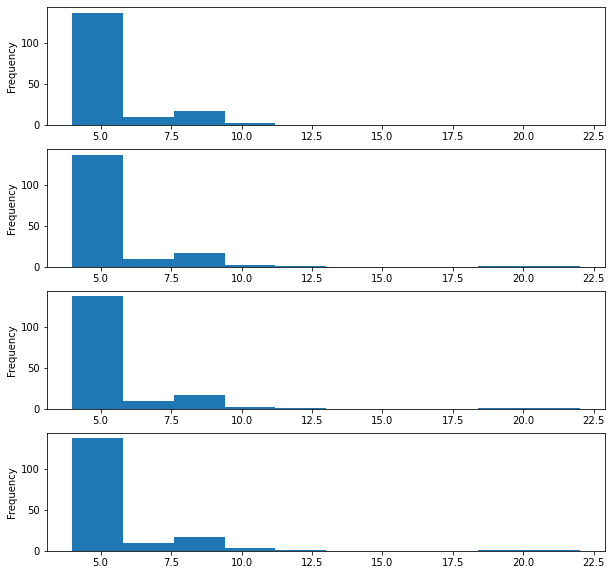

In [28]:
fig, ax = plt.subplots(figsize=(10,10), ncols=1, nrows=len(std_permutations))
for std in range(len(std_permutations)):
    count_outliers[std_permutations[std]].counts.plot.hist(ax=ax[std])

In [29]:
dups = pd.merge(dups, v_counts, how='outer')

In [30]:
count_outliers[(2,3)]

,pin,counts
0,8121220400000,22
1,17171020430000,20
2,17172140050000,12
3,17181030150000,11
4,17181030140000,11
...,...,...
165,31144140090000,4
166,10272190300000,4
167,20362170020000,4
168,15353170240000,4


/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(257, 0.00954326030449313), (258, 0.009580393613070925), (506, 0.018789454140363905), (519, 0.01927218715187523)]


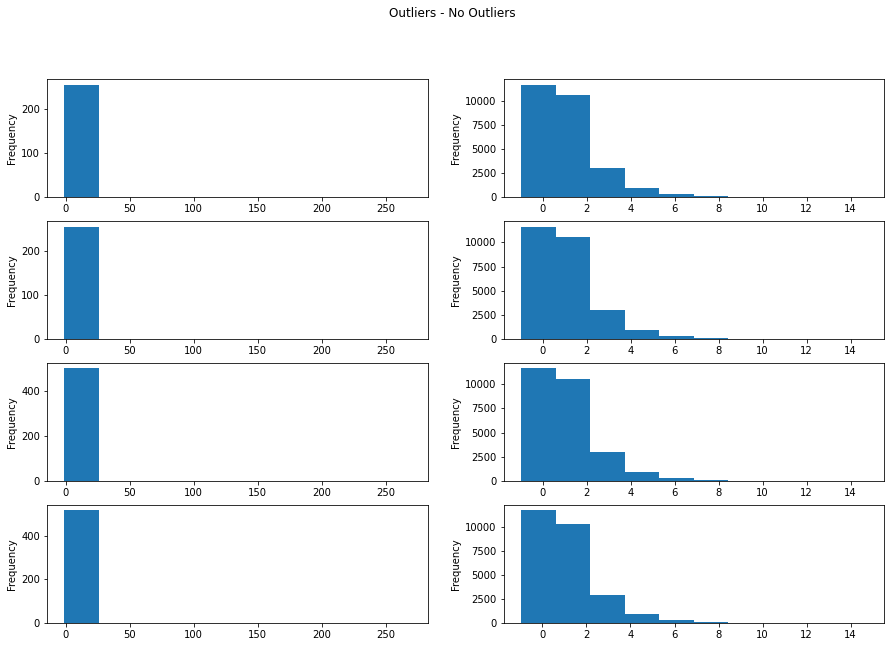

In [31]:
std_permutations = [(4,4), (3,4), (3,3), (2,3)]
volatile_outliers = plot_std(sales, 'township_code', 'pct', std_permutations)

In [32]:
volatile_outliers[(2,3)]

,township_code,class,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10,class_mean_sale_log10,diff_from_class_mean_sale_log10,town_class_mean_sale_log10,diff_from_town_class_mean_sale_log10
55,39,278,24024180110000,2021.0,2021-02-08 00:00:00+00:00,465000.0,5.667453,7174665.0,2110407210,01,...,148.278061,0.001807,12.285714,0.916577,5.317156,0.350297,5.698623,0.031170,5.529629,0.137824
168,77,278,16032160430000,2021.0,2021-07-19 00:00:00+00:00,397500.0,5.599337,7226615.0,2121725028,01,...,187.323280,0.002639,11.421875,1.579825,5.495277,0.104061,5.698623,0.099286,6.035582,0.436244
311,77,204,16234180270000,2022.0,2022-02-22 00:00:00+00:00,230000.0,5.361728,7304181.0,2205639015,01,...,124.593716,0.002905,6.931034,1.579825,5.495277,0.133549,5.553891,0.192163,5.464908,0.103181
566,72,205,20312250080000,2021.0,2021-10-06 00:00:00+00:00,269900.0,5.431203,7273313.0,2134912090,01,...,162.786490,0.003276,7.996667,1.893620,5.177319,0.253884,5.431455,0.000252,5.226018,0.205185
668,73,205,14193270030000,2021.0,2021-06-14 00:00:00+00:00,100000.0,5.000000,7219182.0,2121441044,01,...,47.014575,0.002351,-0.883041,0.500255,5.951049,0.951049,5.431455,0.431455,5.866271,0.866271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202677,14,202,25311250210000,2019.0,2019-05-01 00:00:00+00:00,135000.0,5.130334,97702754.0,1915717080,01,...,143.617021,0.005458,9.800000,2.281684,5.009826,0.120508,5.152864,0.022530,4.867326,0.263008
207125,13,212,28111210120000,2021.0,2021-04-01 00:00:00+00:00,235000.0,5.371068,7197380.0,2115507231,01,...,36.770458,0.000840,0.044444,1.023700,5.206291,0.164777,5.548905,0.177837,5.292352,0.078716
213655,19,208,22243060050000,2021.0,2021-11-03 00:00:00+00:00,402000.0,5.604226,7280716.0,2133501110,01,...,81.657526,0.001138,0.109731,0.465594,5.590998,0.013228,5.971439,0.367213,5.817235,0.213009
215500,20,205,12254100160000,2021.0,2021-07-20 00:00:00+00:00,625000.0,5.795880,7228673.0,2122134072,05,...,347.029428,0.003218,6.352941,0.761925,5.406036,0.389844,5.431455,0.364425,5.415460,0.380420


## Length of Property Holding

In [33]:
sales['days_since_last_transaction'] = sales.sort_values('sale_date').groupby('pin')['sale_date'].diff().apply(lambda x: x.days)

<AxesSubplot:ylabel='Frequency'>

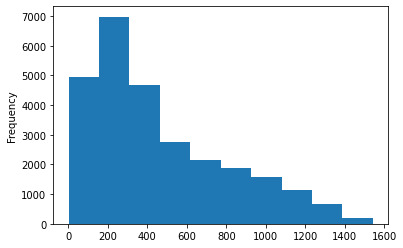

In [34]:
sales.days_since_last_transaction.plot.hist()

In [35]:
sales.days_since_last_transaction.describe()

count    26930.000000
mean       463.553806
std        343.382068
min          1.000000
25%        210.000000
50%        365.000000
75%        680.000000
max       1543.000000
Name: days_since_last_transaction, dtype: float64

/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(51, 0.0018937987374675084), (51, 0.0018937987374675084), (178, 0.006609728926847382), (186, 0.006906795395469736)]


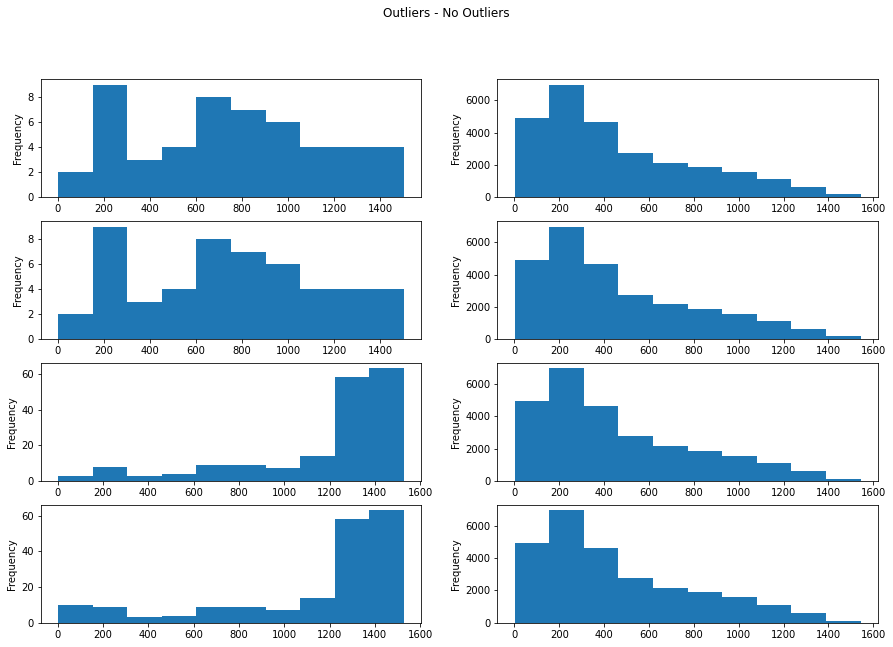

In [36]:
holding_outliers = plot_std(sales, 'township_code', 'days_since_last_transaction', std_permutations)

/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(3, 0.00011139992573338285), (3, 0.00011139992573338285), (97, 0.003601930932046045), (97, 0.003601930932046045)]


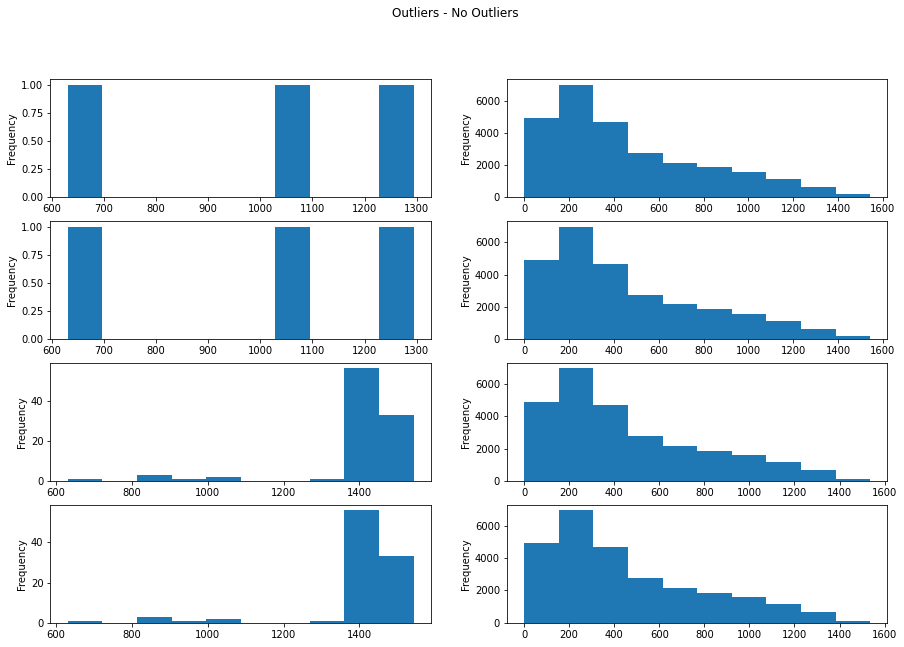

In [37]:
class_holding_outliers = plot_std(sales, 'class', 'days_since_last_transaction', std_permutations)

## Growth Rates

In [38]:
dates = dups.groupby('pin')['sale_date'].agg(['first','last']).reset_index()

In [39]:
firsts = dates[['pin', 'first']].copy()
firsts.rename(columns= {'first': 'sale_date'}, inplace=True)
lasts = dates[['pin', 'last']].copy()
lasts.rename(columns= {'last': 'sale_date'}, inplace=True)

In [40]:
first_transactions = pd.merge(dups, firsts)
last_tranasactions = pd.merge(dups, lasts)

In [41]:
t = last_tranasactions.pin.value_counts()
last_tranasactions = last_tranasactions[last_tranasactions.pin.isin(t.index[~t.gt(1)])]
t = first_transactions.pin.value_counts()
first_transactions = first_transactions[first_transactions.pin.isin(t.index[~t.gt(1)])]

In [42]:
transactions = pd.concat([first_transactions, last_tranasactions], ignore_index=True)

In [43]:
transactions['total_pct'] = transactions.sort_values('sale_date').groupby('pin')['sale_price'].pct_change()
transactions.total_pct.mean()

1.3367803977015842

In [44]:
transactions.total_pct.describe()

count    24641.000000
mean         1.336780
std          2.445789
min         -0.992200
25%          0.266154
50%          0.797468
75%          1.762070
max        269.114943
Name: total_pct, dtype: float64

In [45]:
transactions[transactions.township_code == 76].total_pct.describe()

count    266.000000
mean       0.919164
std        1.403367
min       -0.610577
25%        0.091097
50%        0.368661
75%        1.120925
max       11.235294
Name: total_pct, dtype: float64

<AxesSubplot:ylabel='Frequency'>

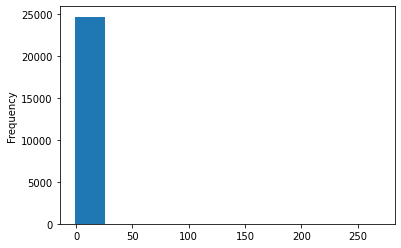

In [46]:
transactions.total_pct.plot.hist()

In [47]:
transactions.groupby('township_code')['total_pct'].median()

township_code
10    0.183328
11    0.825000
12    1.101509
13    0.800008
14    2.047619
15    1.182295
16    0.428571
17    0.375000
18    0.375810
19    0.223684
20    0.592430
21    0.508219
22    0.357149
23    0.292660
24    0.430894
25    0.262081
26    0.392157
27    0.293527
28    0.265207
29    0.233280
30    0.481664
31    0.860875
32    1.066667
33    0.122666
34    0.542202
35    0.367647
36    0.772297
37    1.486486
38    0.333333
39    0.686391
70    1.803321
71    0.604048
72    1.466416
73    0.170732
74    0.068750
75    0.287001
76    0.368661
77    1.254593
Name: total_pct, dtype: float64

In [48]:
transactions.groupby('census_tract_geoid')['total_pct'].mean()

census_tract_geoid
1.703180e+10    0.957043
1.703180e+10    0.816034
1.703180e+10    0.425161
1.703180e+10    0.276651
1.703180e+10    0.597634
                  ...   
1.703181e+10    0.221085
1.703181e+10    1.007140
1.703181e+10    0.690710
1.703181e+10    0.250991
1.703181e+10    0.280995
Name: total_pct, Length: 148, dtype: float64

/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(247, 0.010023943833448318), (248, 0.010064526602004789), (481, 0.019520311675662514), (496, 0.020129053204009578)]


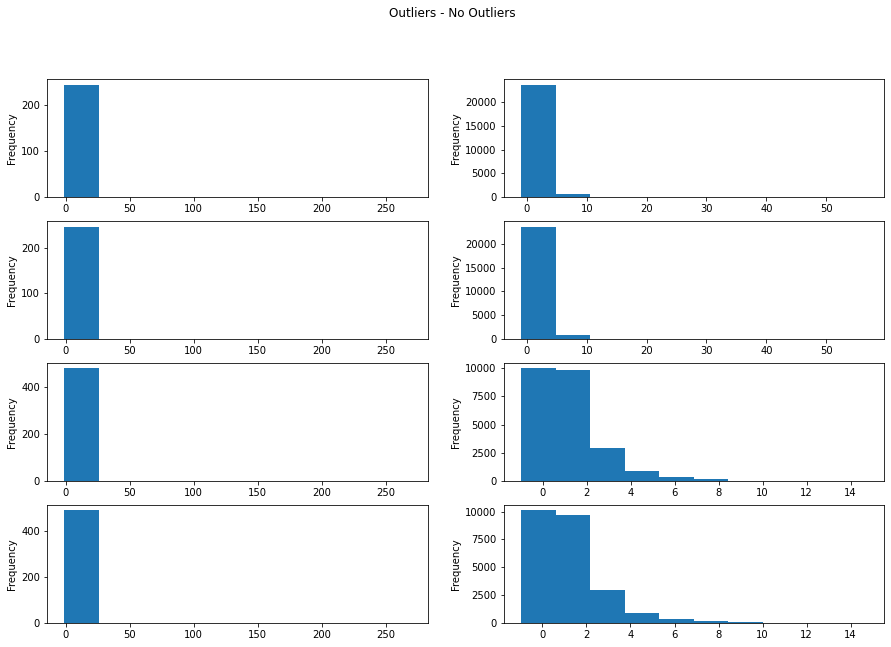

In [49]:
town_growth = plot_std(transactions, 'township_code', 'total_pct', std_permutations)

/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_1392501/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(271, 0.13290828837665522), (271, 0.13290828837665522), (272, 0.13339872486512996), (272, 0.13339872486512996)]


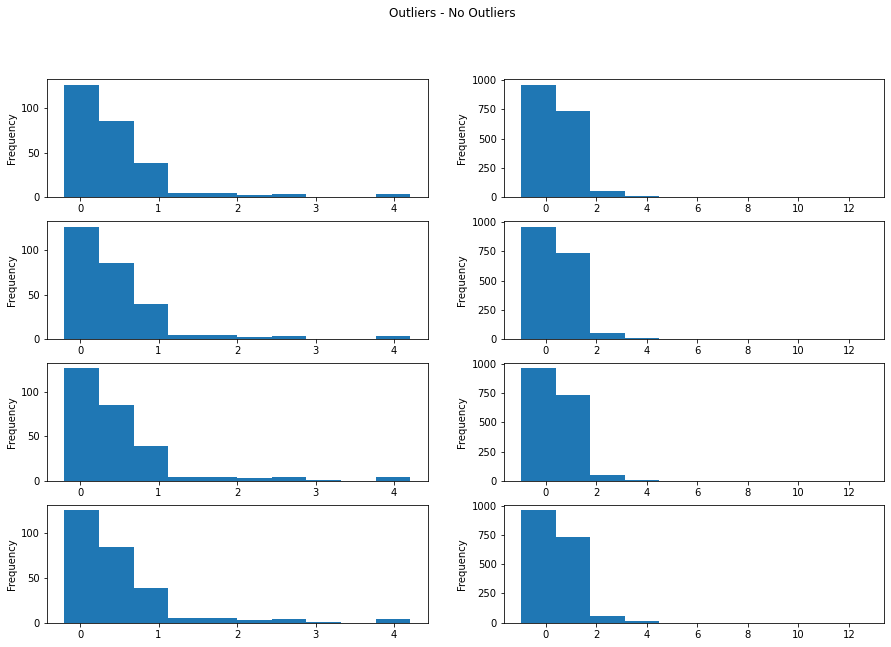

In [50]:
census_growth = plot_std(transactions, 'census_tract_geoid', 'total_pct', std_permutations)

## Moving Towards/Away From Mean

In [51]:
temp = dups.sort_values('sale_date').groupby(['pin'])['diff_from_township_mean_sale_log10'].shift()
dups['town_movement'] = dups['diff_from_township_mean_sale_log10'].lt(temp).astype(float) # 0 is moving away, 1 is moving towards


temp = dups.sort_values('sale_date').groupby(['pin'])['diff_from_class_mean_sale_log10'].shift()
dups['class_movement'] = dups['diff_from_class_mean_sale_log10'].lt(temp).astype(float) # 0 is moving away, 1 is moving towards

temp = dups.sort_values('sale_date').groupby(['pin'])['diff_from_town_class_mean_sale_log10'].shift()
dups['town_class_movement'] = dups['diff_from_town_class_mean_sale_log10'].lt(temp).astype(float) # 0 is moving away, 1 is moving towards


In [52]:
dups.town_movement.value_counts()

0.0    35104
1.0    16467
Name: town_movement, dtype: int64

In [53]:
dups.class_movement.value_counts()

0.0    35407
1.0    16164
Name: class_movement, dtype: int64

In [54]:
dups.town_class_movement.value_counts()

0.0    35805
1.0    15766
Name: town_class_movement, dtype: int64

In [55]:
sales['class'].value_counts()

203    67009
211    30869
202    22687
278    18448
234    17955
205    15446
295    14581
204     9798
206     7137
207     5261
210     2649
208     2524
212     2247
209     1244
297      264
213        8
218        6
299        5
219        1
Name: class, dtype: int64

In [56]:
sales['township_code'].nunique()

38

In [57]:
sales['class'].nunique() * sales['township_code'].nunique()

722

In [58]:
sales['class'].nunique() * sales['township_code'].nunique() * 6

4332

In [59]:
sales = pd.merge(sales, dups, how='outer')
sales

,township_code,class,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,diff_from_township_mean_sale_log10,class_mean_sale_log10,diff_from_class_mean_sale_log10,town_class_mean_sale_log10,diff_from_town_class_mean_sale_log10,days_since_last_transaction,counts,town_movement,class_movement,town_class_movement
0,29,295,2092050370000,2019.0,2019-05-01 00:00:00+00:00,201000.0,5.303196,96812985.0,1915417094,01,...,0.219564,5.455649,0.152453,5.420968,0.117771,NaN,NaN,NaN,NaN,NaN
1,72,205,20311070380000,2019.0,2019-09-01 00:00:00+00:00,215000.0,5.332438,98075139.0,1927355080,01,...,0.155120,5.431455,0.099017,5.226018,0.106421,NaN,NaN,NaN,NaN,NaN
2,24,206,10201120410000,2018.0,2018-07-01 00:00:00+00:00,540000.0,5.732394,97373057.0,1822817046,01,...,0.164411,5.817017,0.084623,5.767597,0.035203,NaN,NaN,NaN,NaN,NaN
3,27,203,16183030040000,2022.0,2022-02-11 00:00:00+00:00,595000.0,5.774517,7321053.0,2206001050,01,...,0.123983,5.304630,0.469887,5.560049,0.214468,NaN,NaN,NaN,NaN,NaN
4,24,203,10272320440000,2020.0,2020-04-01 00:00:00+00:00,285000.0,5.454845,96592558.0,2019607192,01,...,0.113138,5.304630,0.150215,5.508650,0.053805,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218134,38,295,3081110200000,2019.0,2019-07-01 00:00:00+00:00,553125.0,5.742823,98482344.0,1919755022,05,...,0.200036,5.455649,0.287174,5.421377,0.321447,NaN,NaN,NaN,NaN,NaN
218135,72,202,25212060060000,2021.0,2021-07-07 00:00:00+00:00,61000.0,4.785330,7209461.0,2120021039,01,...,0.391989,5.152864,0.367534,5.091380,0.306051,NaN,NaN,NaN,NaN,NaN
218136,35,278,7294030160000,2021.0,2021-08-30 00:00:00+00:00,220000.0,5.342423,7249327.0,2126546039,01,...,0.110319,5.698623,0.356200,5.616849,0.274426,NaN,NaN,NaN,NaN,NaN
218137,77,203,13251310310000,2018.0,2018-05-01 00:00:00+00:00,625000.0,5.795880,96260041.0,1815912107,01,...,0.300604,5.304630,0.491250,5.321454,0.474426,NaN,NaN,NaN,NaN,NaN


## Human-Readable DataFrame Construction

In [60]:
std_permutations = [(4,4), (3,4), (3,3), (2,3), (2,2), (1,2), (1,1), (1,0), (2,0), (3,0), (4,0), (0,1), (0,2), (0,3), (0,4)]
sales_iterates = ['sale_price_log10', 'price_per_sqft_log10', 'days_since_last_transaction']
dups_iterates = ['counts', 'pct']
pd_data = {}

def sep_std(df: pd.DataFrame, group: str, col: str, permuts: tuple) -> (int, float):

    if col == 'pct':
        df = df[df.town_class_movement == 0]
    std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]

    pct = round(len(std_outliers) / len(sales), 3)

    length = len(std_outliers)

    return length, pct

sale = {}
for sal in sales_iterates:
    pd_data.setdefault(sal, [])
    pd_data.setdefault(sal + '_pct', [])
    for std in std_permutations:
        length, stat = sep_std(sales, 'township_code', sal, std)
        pd_data[sal].append(length)
        pd_data[sal + '_pct'].append(stat)

dupie = {}
for dup in dups_iterates:
    pd_data.setdefault(dup, [])
    pd_data.setdefault(dup + '_pct', [])
    for std in std_permutations:
        length, stat = sep_std(dups, 'township_code', dup, std)
        pd_data[dup].append(length)
        pd_data[dup + '_pct'].append(stat)

transac = {}
for trac in ['total_pct']:
    pd_data.setdefault(trac, [])
    pd_data.setdefault(trac + '_pct', [])
    for std in std_permutations:
        length, stat = sep_std(transactions, 'township_code', trac, std)
        pd_data[trac].append(length)
        pd_data[trac + '_pct'].append(stat)

human = pd.DataFrame(pd_data, index=std_permutations)

/tmp/ipykernel_1392501/1882304569.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]
/tmp/ipykernel_1392501/1882304569.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]
/tmp/ipykernel_1392501/1882304569.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]
/tmp/ipykernel_1392501/1882304569.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]


In [61]:
sides = ['both','both','both','both','both', 'both', 'both', 'left', 'left', 'left', 'left', 'right','right', 'right', 'right']
human.reset_index(inplace=True)
human['side'] = sides

In [62]:
human

,index,sale_price_log10,sale_price_log10_pct,price_per_sqft_log10,price_per_sqft_log10_pct,days_since_last_transaction,days_since_last_transaction_pct,counts,counts_pct,pct,pct_pct,total_pct,total_pct_pct,side
0,"(4, 4)",610,0.003,372,0.002,51,0.000,352,0.002,91,0.000,247,0.001,both
1,"(3, 4)",1663,0.008,532,0.002,51,0.000,352,0.002,92,0.000,248,0.001,both
2,"(3, 3)",2189,0.010,1249,0.006,178,0.001,1084,0.005,189,0.001,481,0.002,both
3,"(2, 3)",7875,0.036,3766,0.017,186,0.001,1084,0.005,227,0.001,496,0.002,both
4,"(2, 2)",10492,0.048,7006,0.032,1329,0.006,4490,0.021,542,0.002,1085,0.005,both
5,"(1, 2)",33971,0.156,38604,0.177,4460,0.020,4616,0.021,1441,0.007,2229,0.010,both
6,"(1, 1)",56307,0.258,68601,0.314,7965,0.037,5848,0.027,2559,0.012,4119,0.019,both
7,"(1, 0)",148950,0.683,140736,0.645,13779,0.063,6145,0.028,5404,0.025,10477,0.048,left
8,"(2, 0)",125471,0.575,109138,0.500,10648,0.049,6019,0.028,4505,0.021,9333,0.043,left
9,"(3, 0)",119785,0.549,106621,0.489,10640,0.049,6019,0.028,4467,0.020,9318,0.043,left


In [63]:

std_permutations = [(4,4), (3,4), (3,3), (2,3), (2,2), (1,2), (1,1), (1,0), (2,0), (3,0), (4,0), (0,1), (0,2), (0,3), (0,4)]
sales_iterates = ['sale_price_log10', 'price_per_sqft_log10', 'days_since_last_transaction']
dups_iterates = ['counts', 'pct']
non_overs = {}

def over_std(df: pd.DataFrame, group: str, col: str, permuts: tuple) -> (pd.DataFrame):

    if col == 'pct':
        df = df[df.town_class_movement == 0]
    std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]

    return std_outliers

for std in std_permutations:
    outties = []
    for it in sales_iterates + dups_iterates:
        if it in dups_iterates:
            outties.append(over_std(dups, 'township_code', it, std))
        else:
            outties.append(over_std(sales, 'township_code', it, std))
        all_outs = pd.concat(outties).drop_duplicates()
        non_overs[std] = len(sales[~sales.sale_key.isin(all_outs.sale_key)])

human.assign(non_flagged=list(non_overs.values()), inplace=True)

/tmp/ipykernel_1392501/1000447817.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]
/tmp/ipykernel_1392501/1000447817.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]
/tmp/ipykernel_1392501/1000447817.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]
/tmp/ipykernel_1392501/1000447817.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]


,index,sale_price_log10,sale_price_log10_pct,price_per_sqft_log10,price_per_sqft_log10_pct,days_since_last_transaction,days_since_last_transaction_pct,counts,counts_pct,pct,pct_pct,total_pct,total_pct_pct,side,non_flagged,inplace
0,"(4, 4)",610,0.003,372,0.002,51,0.000,352,0.002,91,0.000,247,0.001,both,216714,True
1,"(3, 4)",1663,0.008,532,0.002,51,0.000,352,0.002,92,0.000,248,0.001,both,215521,True
2,"(3, 3)",2189,0.010,1249,0.006,178,0.001,1084,0.005,189,0.001,481,0.002,both,213447,True
3,"(2, 3)",7875,0.036,3766,0.017,186,0.001,1084,0.005,227,0.001,496,0.002,both,205746,True
4,"(2, 2)",10492,0.048,7006,0.032,1329,0.006,4490,0.021,542,0.002,1085,0.005,both,196444,True
5,"(1, 2)",33971,0.156,38604,0.177,4460,0.020,4616,0.021,1441,0.007,2229,0.010,both,147625,True
6,"(1, 1)",56307,0.258,68601,0.314,7965,0.037,5848,0.027,2559,0.012,4119,0.019,both,108298,True
7,"(1, 0)",148950,0.683,140736,0.645,13779,0.063,6145,0.028,5404,0.025,10477,0.048,left,21365,True
8,"(2, 0)",125471,0.575,109138,0.500,10648,0.049,6019,0.028,4505,0.021,9333,0.043,left,37957,True
9,"(3, 0)",119785,0.549,106621,0.489,10640,0.049,6019,0.028,4467,0.020,9318,0.043,left,41723,True


## Overlaps

In [64]:
std_permutations = [(4,4), (3,4), (3,3), (2,3), (2,2), (1,2), (1,1), (1,0), (2,0), (3,0), (4,0), (0,1), (0,2), (0,3), (0,4)]

def overlap(group: str, cols: list, permut: tuple) -> pd.DataFrame:
    """
    cols is list where all values get concat together once groupby done.
    """
    sales_iterates = ['sale_price_log10', 'price_per_sqft_log10', 'days_since_last_transaction']
    dups_iterates = ['counts', 'pct']

    conc = []
    for c in cols:
        if c in sales_iterates:
            conc.append(sales.dropna(subset=[group, c])[sales.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])
        else:
            conc.append(dups.dropna(subset=[group, c])[dups.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])

    concated = pd.concat(conc, ignore_index=True)
    concated.pin.value_counts()
    v_counts = concated.sale_key.value_counts().reset_index().rename(columns={'index':'sale_key', 'sale_key':'counts'})

    return v_counts

flag_counts = []

for std in std_permutations:
    flags = overlap('township_code', sales_iterates + dups_iterates, std)
    index_length = [std] * len(flags)
    flags['permutation'] = index_length
    flags.set_index('permutation')
    flag_counts.append(flags)

flags_perms = pd.concat(flag_counts)

/tmp/ipykernel_1392501/3075294358.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conc.append(sales.dropna(subset=[group, c])[sales.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])
/tmp/ipykernel_1392501/3075294358.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conc.append(sales.dropna(subset=[group, c])[sales.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])
/tmp/ipykernel_1392501/3075294358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conc.append(dups.dropna(subset=[group, c])[dups.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])
/tmp/ipykernel_1392501/3075294358.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conc.append(sales.dropna(subset=[group, c])[sales.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])
/tmp/ipyke

In [65]:
flags_perms[flags_perms.permutation == (0,4)]

,sale_key,counts,permutation
0,7175127.0,5,"(0, 4)"
1,97295701.0,5,"(0, 4)"
2,7165107.0,5,"(0, 4)"
3,7263838.0,5,"(0, 4)"
4,98074662.0,5,"(0, 4)"
...,...,...,...
178200,97592789.0,1,"(0, 4)"
178201,97075378.0,1,"(0, 4)"
178202,7185587.0,1,"(0, 4)"
178203,98041346.0,1,"(0, 4)"


<AxesSubplot:ylabel='Frequency'>

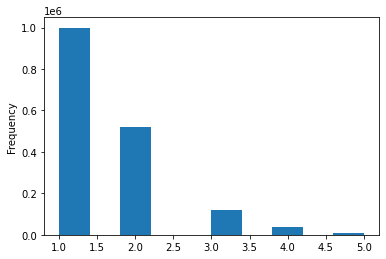

In [66]:
# make histograms
# what are axis?
flags_perms.counts.plot.hist()

In [67]:
sales_iterates = ['sale_price_log10', 'price_per_sqft_log10'] # 'days_since_last_transaction']
dups_iterates = ['counts', 'pct']

In [68]:
running = 0
for col in sales_iterates + dups_iterates:
    running += sales[col].std()
    print(running)

mean = running / len(sales_iterates + dups_iterates)
mean

0.3601971967891346
0.3616197236543691
1.1465095472622602
3.4666439183290736


0.8666609795822684

## Microdata Columns

In [98]:
move = None
std = None
labels = ['Not Outlier','Price Change Departing Mean', 'Valuation', 'Volatility']
details = ['Not Outlier', f'Price {move} away from mean', f'High valuation {std} from mean', 'Many transactions in given timeframe']


def get_thresh(df: pd.DataFrame, cols: list, permut: tuple):
    stds = {}

    for col in cols:
        grouped = df.dropna(subset=['township_code', col]).groupby(['township_code', 'class'])[col]
        lower_limit = grouped.mean() - (grouped.std() * permut[0])
        upper_limit = grouped.mean() + (grouped.std() * permut[1])

        lower_limit = lower_limit.to_dict()
        upper_limit = upper_limit.to_dict()
        limits =  {x: (lower_limit.get(x, 0), upper_limit.get(x, 0))
                    for x in set(lower_limit).union(upper_limit)}
        stds[col] = limits

    return stds

In [99]:
columns = ['sale_price_log10', 'price_per_sqft_log10', 'counts', 'pct', 'days_since_last_transaction']
holds = get_thresh(sales, columns, (2,2))